In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import time

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from metadata import *
from data_manager import *
from learning_utilities import *

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Setting environment for AWS compute node


No vtk
File does not exist: /shared/CSHL_data_processed/MD635/MD635_anchor.txt
File does not exist: /shared/CSHL_data_processed/MD635/MD635_sorted_filenames.txt
File does not exist: /shared/CSHL_data_processed/MD635/MD635_cropbox.txt
File does not exist: /shared/CSHL_data_processed/MD635/MD635_cropbox.txt
File does not exist: /shared/CSHL_data_processed/MD657/MD657_anchor.txt
File does not exist: /shared/CSHL_data_processed/MD657/MD657_sorted_filenames.txt
File does not exist: /shared/CSHL_data_processed/MD657/MD657_cropbox.txt
File does not exist: /shared/CSHL_data_processed/MD657/MD657_cropbox.txt


In [3]:
from sklearn.externals import joblib

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import GradientBoostingClassifier 

sys.path.append('/home/yuncong/csd395/xgboost/python-package')
try:
    from xgboost.sklearn import XGBClassifier
except:
    sys.stderr.write('xgboost is not loaded.')

xgboost is not loaded.

In [4]:
# structures_to_sample = all_known_structures

# negative_labels_to_sample = [s + '_negative' for s in structures_to_sample]

# margins_to_sample = [500] # (200: 100 um, 500: 250 um)
# surround_labels_to_sample = [convert_to_surround_name(s, margin=m, suffix=surr_l) 
#                              for m in margins_to_sample
#                              for s in structures_to_sample 
#                              for surr_l in structures_to_sample + ['noclass'] 
#                              if surr_l != s]

# labels_to_sample = structures_to_sample + negative_labels_to_sample + surround_labels_to_sample + ['noclass']

# Train Classifiers

In [5]:
classifier_settings

,model,margin,train_set_id,neg_composition,sample_weighting
classifier_id,,,,,
30,lr,500,20/21,neg_has_all_surround,NaN
31,lr,500,21/22,neg_has_all_surround,NaN
32,lr,500,20/22,neg_has_all_surround,NaN
33,gb1,500,20/21,neg_has_all_surround,NaN
34,gb1,500,21/22,neg_has_all_surround,NaN
35,gb1,500,20/22,neg_has_all_surround,NaN


In [28]:
classifier_id = 35
classifier_properties = classifier_settings.loc[classifier_id]

margin = classifier_properties['margin']
model = classifier_properties['model']
sample_weighting = classifier_properties['sample_weighting']
neg_composition = classifier_properties['neg_composition']

In [29]:
# Determine which labels to load.

structures_to_sample = all_known_structures
negative_labels_to_sample = [s + '_negative' for s in structures_to_sample]

margins_to_sample = [margin] # (200: 100 um, 500: 250 um)
surround_positive_labels_to_sample = [convert_to_surround_name(s, margin=m, suffix=surr_l) 
                             for m in margins_to_sample
                             for s in structures_to_sample 
                             for surr_l in structures_to_sample
                             if surr_l != s]
surround_noclass_labels_to_sample = [convert_to_surround_name(s, margin=m, suffix='noclass') 
                             for m in margins_to_sample
                             for s in structures_to_sample]

if neg_composition == 'neg_has_everything_else':
    labels_to_sample = structures_to_sample + negative_labels_to_sample
elif neg_composition == 'neg_has_only_surround_noclass':
    labels_to_sample = structures_to_sample + surround_noclass_labels_to_sample + ['noclass']
elif neg_composition == 'neg_has_all_surround':
    labels_to_sample = structures_to_sample + surround_positive_labels_to_sample + surround_noclass_labels_to_sample + ['noclass']

In [30]:
# Load training dataset.

training_set_ids = map(int, str(classifier_properties['train_set_id']).split('/'))
training_features, training_addresses = load_datasets(training_set_ids, labels_to_sample=labels_to_sample)
    
assert set(training_addresses.keys()) == set(training_features.keys()), \
    'Training features and training addresses are not consistent.'

rm -rf /shared/CSHL_classifiers/datasets/dataset_20/patch_addresses.pkl && mkdir -p /shared/CSHL_classifiers/datasets/dataset_20
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_20/patch_addresses.pkl /shared/CSHL_classifiers/datasets/dataset_20/patch_addresses.pkl


Child returned 0
Child returned 0
0.59 seconds.


rm -rf /shared/CSHL_classifiers/datasets/dataset_20/patch_features.hdf && mkdir -p /shared/CSHL_classifiers/datasets/dataset_20
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_20/patch_features.hdf /shared/CSHL_classifiers/datasets/dataset_20/patch_features.hdf


Child returned 0
Child returned 0
1.55 seconds.


rm -rf /shared/CSHL_classifiers/datasets/dataset_22/patch_addresses.pkl && mkdir -p /shared/CSHL_classifiers/datasets/dataset_22
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_22/patch_addresses.pkl /shared/CSHL_classifiers/datasets/dataset_22/patch_addresses.pkl


Child returned 0
Child returned 0
0.59 seconds.


rm -rf /shared/CSHL_classifiers/datasets/dataset_22/patch_features.hdf && mkdir -p /shared/CSHL_classifiers/datasets/dataset_22
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/datasets/dataset_22/patch_features.hdf /shared/CSHL_classifiers/datasets/dataset_22/patch_features.hdf


Child returned 0
Child returned 0
1.77 seconds.


In [31]:
labels_found = training_features.keys()
structures_found = set([convert_to_original_name(l) for l in labels_found]) - {'noclass'}

In [32]:
setting_dir = os.path.join(os.path.join(CLF_ROOTDIR, 'setting_%d' % classifier_id))

In [33]:
clf_dir = create_if_not_exists(os.path.join(setting_dir, 'classifiers'))

for structure in structures_found:

    print structure
    
    #############################
    ## Define Positive Samples ##
    #############################
    
    features_pos = training_features[structure]
    n_pos = len(features_pos)
    
    #############################
    ## Define Negative Samples ##
    #############################
    
#     if setting in [1, 3, 4, 5, 6, 7]:
    if neg_composition == 'neg_has_only_surround_noclass':
        neg_classes = [convert_to_surround_name(structure, margin=margin, suffix='noclass')]
#     elif setting in [2, 10, 23, 24, 25, 26]:
    elif neg_composition == 'neg_has_all_surround':
        neg_classes = [convert_to_surround_name(structure, margin=margin, suffix='noclass')]
        for surr_s in structures_found:
            c = convert_to_surround_name(structure, margin=margin, suffix=surr_s)
            if c in labels_found:
                neg_classes.append(c)
#     elif setting in [8,9,11]:
    elif neg_composition == 'neg_has_everything_else':
        neg_classes = [structure + '_negative']
    else:
        raise Exception('neg_composition %s is not recognized.' % neg_composition)

    features_neg = np.concatenate([training_features[neg_class] for neg_class in neg_classes])
        
    n_neg = len(features_neg)
        
    ###########################
    ## Define Sample Weights ##
    ###########################
    
#     if setting == 9:
    if sample_weighting == 'weighted':
        neg_distances = np.concatenate([distances_to_structures[neg_class][structure] for neg_class in neg_classes])
            
        sample_weights_neg = np.ones((n_neg,))
        sample_weights_neg[neg_distances > thresh] = diminishing(neg_distances[neg_distances > thresh])
        sample_weights = np.r_[np.ones((n_pos,)), sample_weights_neg]
    else:
        sample_weights = None
    
    ###########################################################################################

    train_data = np.r_[features_pos, features_neg]
    train_labels = np.r_[np.ones((features_pos.shape[0], )), 
                         -np.ones((features_neg.shape[0], ))]
    
#     n_train = len(train_labels0)
#     ri = np.random.choice(range(n_train), size=100, replace=False)
#     train_data = train_data0[ri]
#     train_labels = train_labels0[ri]
    
    ##################
    ## Define Model ##
    ##################
    
#     if setting in [1, 2, 8, 9, 10, 11, 23, 24]:
    if model == 'lr':
        clf = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, 
                                 fit_intercept=True, intercept_scaling=1, class_weight=None, 
                                 random_state=None, solver='liblinear', max_iter=100, multi_class='ovr', 
                                 verbose=0, warm_start=False, n_jobs=1)
            
#     elif setting == 3:
    elif model == 'lin_svc':
        clf = SVC(C=1.0, kernel='linear', degree=3, gamma='auto', coef0=0.0, shrinking=True, 
                  probability=True, tol=0.001, cache_size=1000, max_iter=-1,
              decision_function_shape=None, random_state=None)
        

#     elif setting == 4:
    elif model == 'lin_svc_calib':
        
        sv_uncalibrated = LinearSVC(penalty='l2', loss='squared_hinge', dual=True, tol=0.0001, 
                                C=1.0, multi_class='ovr', 
                                fit_intercept=True, intercept_scaling=1, max_iter=100)
        clf = CalibratedClassifierCV(sv_uncalibrated)
        
        
#     elif setting in [5]:        
    elif model == 'xgb1':
        clf = XGBClassifier(max_depth=3, learning_rate=0.2, n_estimators=200, 
                            silent=False, objective='binary:logistic', nthread=-1, gamma=0, 
                            min_child_weight=20, max_delta_step=0, subsample=.8, 
                            colsample_bytree=.8, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, 
                            scale_pos_weight=1, base_score=0.5, seed=0, missing=None)
        
#     elif setting in [6, 25]:
    elif model == 'gb1':
        clf = GradientBoostingClassifier(loss='deviance', learning_rate=0.3, n_estimators=200, 
                                         subsample=1., criterion='friedman_mse', 
                                         min_samples_split=50, min_samples_leaf=20, 
                                         min_weight_fraction_leaf=0.0, max_depth=3, 
                                         min_impurity_split=1e-07, init=None, random_state=None, 
                                         max_features=None, verbose=1, max_leaf_nodes=None, 
                                         warm_start=False, presort='auto')
        
#     elif setting in [7, 26]:     
    elif model == 'gb2':
        clf = GradientBoostingClassifier(loss='deviance', learning_rate=0.3, n_estimators=100, 
                                         subsample=1., criterion='friedman_mse', 
                                         min_samples_split=50, min_samples_leaf=20, 
                                         min_weight_fraction_leaf=0.0, max_depth=5, 
                                         min_impurity_split=1e-07, init=None, random_state=None, 
                                         max_features=None, verbose=1, max_leaf_nodes=None, 
                                         warm_start=False, presort='auto')
        
    
    else:
        sys.stderr.write('Setting is not recognized.\n')

    
    t = time.time()    
    clf.fit(train_data, train_labels, sample_weight=sample_weights)
    sys.stderr.write('Fitting classifier: %.2f seconds\n' % (time.time() - t))

    clf_fp = os.path.join(clf_dir, '%(structure)s_clf_setting_%(setting)d.dump' % \
                                  dict(structure=structure, setting=classifier_id))
    
    joblib.dump(clf, clf_fp)
    
    upload_from_ec2_to_s3(clf_fp)

Tz
      Iter       Train Loss   Remaining Time 
         1           1.0705            1.18m
         2           0.9191            1.18m
         3           0.8193            1.17m
         4           0.7452            1.17m
         5           0.6896            1.16m
         6           0.6432            1.16m
         7           0.6059            1.16m
         8           0.5749            1.16m
         9           0.5471            1.15m
        10           0.5187            1.15m
        20           0.3661            1.09m
        30           0.2857            1.01m
        40           0.2297           56.91s
        50           0.1899           53.14s
        60           0.1568           49.46s
        70           0.1313           45.84s
        80           0.1098           42.39s
        90           0.0927           38.82s
       100           0.0781           35.28s
       200           0.0162            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_35/class

Fitting classifier: 70.79 seconds
Child returned 0
0.41 seconds.


Sp5O
      Iter       Train Loss   Remaining Time 
         1           1.1590            1.33m
         2           1.0859            1.29m
         3           1.0295            1.28m
         4           0.9862            1.27m
         5           0.9498            1.27m
         6           0.9205            1.26m
         7           0.8946            1.26m
         8           0.8696            1.22m
         9           0.8494            1.22m
        10           0.8308            1.21m
        20           0.7107            1.12m
        30           0.6389            1.03m
        40           0.5797           57.11s
        50           0.5301           52.89s
        60           0.4914           48.75s
        70           0.4506           45.08s
        80           0.4168           41.31s
        90           0.3838           37.76s
       100           0.3507           34.35s
       200           0.1594            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_35/cla

Fitting classifier: 69.17 seconds
Child returned 0
0.41 seconds.


7n
      Iter       Train Loss   Remaining Time 
         1           1.0678           52.87s
         2           0.8837           52.35s
         3           0.7607           52.30s
         4           0.6802           51.48s
         5           0.6166           51.37s
         6           0.5669           51.19s
         7           0.5262           51.05s
         8           0.4968           50.70s
         9           0.4713           50.30s
        10           0.4471           50.11s
        20           0.3234           47.34s
        30           0.2572           43.47s
        40           0.2083           40.12s
        50           0.1693           37.13s
        60           0.1400           34.32s
        70           0.1158           31.94s
        80           0.0964           29.56s
        90           0.0818           26.96s
       100           0.0681           24.50s
       200           0.0135            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_35/class

Fitting classifier: 48.76 seconds
Child returned 0
0.46 seconds.


DC
      Iter       Train Loss   Remaining Time 
         1           1.0137            1.68m
         2           0.9507            1.65m
         3           0.8902            1.67m
         4           0.8430            1.68m
         5           0.8071            1.68m
         6           0.7805            1.67m
         7           0.7573            1.66m
         8           0.7313            1.65m
         9           0.7101            1.62m
        10           0.6889            1.62m
        20           0.5518            1.52m
        30           0.4671            1.43m
        40           0.4102            1.33m
        50           0.3635            1.24m
        60           0.3216            1.16m
        70           0.2898            1.06m
        80           0.2598           58.72s
        90           0.2357           53.61s
       100           0.2143           48.52s
       200           0.0861            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_35/class

Fitting classifier: 96.84 seconds
Child returned 0
0.51 seconds.


5N
      Iter       Train Loss   Remaining Time 
         1           1.1434           50.93s
         2           1.0001           49.86s
         3           0.9089           49.54s
         4           0.8417           49.19s
         5           0.7899           49.00s
         6           0.7469           48.70s
         7           0.7141           48.34s
         8           0.6865           48.09s
         9           0.6616           47.86s
        10           0.6397           47.77s
        20           0.5106           44.20s
        30           0.4354           40.20s
        40           0.3665           37.38s
        50           0.3169           34.43s
        60           0.2708           32.21s
        70           0.2334           29.71s
        80           0.2045           27.14s
        90           0.1779           24.87s
       100           0.1570           22.58s
       200           0.0424            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_35/class

Fitting classifier: 45.59 seconds
Child returned 0
0.41 seconds.


RtTg
      Iter       Train Loss   Remaining Time 
         1           1.1284            1.47m
         2           1.0702            1.46m
         3           1.0242            1.46m
         4           0.9900            1.44m
         5           0.9615            1.43m
         6           0.9356            1.41m
         7           0.9110            1.41m
         8           0.8915            1.40m
         9           0.8733            1.38m
        10           0.8581            1.37m
        20           0.7513            1.25m
        30           0.6740            1.16m
        40           0.6101            1.08m
        50           0.5563            1.01m
        60           0.5166           56.24s
        70           0.4816           51.60s
        80           0.4479           47.27s
        90           0.4160           43.12s
       100           0.3835           39.21s
       200           0.1856            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_35/cla

Fitting classifier: 78.73 seconds
Child returned 0
0.46 seconds.


Pn
      Iter       Train Loss   Remaining Time 
         1           1.0708            1.27m
         2           0.9513            1.24m
         3           0.8578            1.25m
         4           0.7944            1.25m
         5           0.7478            1.23m
         6           0.7071            1.23m
         7           0.6713            1.22m
         8           0.6450            1.22m
         9           0.6232            1.20m
        10           0.6018            1.19m
        20           0.4723            1.12m
        30           0.4073            1.03m
        40           0.3478           58.21s
        50           0.3020           53.94s
        60           0.2636           50.32s
        70           0.2364           46.46s
        80           0.2083           42.77s
        90           0.1833           39.11s
       100           0.1608           35.51s
       200           0.0515            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_35/class

Fitting classifier: 70.96 seconds
Child returned 0
0.51 seconds.


10N
      Iter       Train Loss   Remaining Time 
         1           0.9449            1.13m
         2           0.7909            1.12m
         3           0.6780            1.13m
         4           0.6048            1.13m
         5           0.5475            1.13m
         6           0.5065            1.13m
         7           0.4679            1.13m
         8           0.4410            1.13m
         9           0.4170            1.13m
        10           0.3951            1.13m
        20           0.2841            1.08m
        30           0.2389           58.38s
        40           0.1998           54.17s
        50           0.1667           50.30s
        60           0.1390           46.47s
        70           0.1219           42.62s
        80           0.1020           39.42s
        90           0.0880           36.03s
       100           0.0750           32.71s
       200           0.0178            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_35/clas

Fitting classifier: 66.06 seconds
Child returned 0
0.46 seconds.


LC
      Iter       Train Loss   Remaining Time 
         1           1.1542           49.19s
         2           1.0099           47.99s
         3           0.9105           47.59s
         4           0.8403           47.31s
         5           0.7860           47.05s
         6           0.7471           46.66s
         7           0.7172           46.14s
         8           0.6922           45.96s
         9           0.6674           45.69s
        10           0.6451           45.51s
        20           0.5004           42.25s
        30           0.4182           38.21s
        40           0.3548           35.28s
        50           0.3096           32.22s
        60           0.2716           29.68s
        70           0.2325           27.70s
        80           0.2009           25.52s
        90           0.1761           23.31s
       100           0.1535           21.15s
       200           0.0403            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_35/class

Fitting classifier: 42.94 seconds
Child returned 0
0.46 seconds.


7N
      Iter       Train Loss   Remaining Time 
         1           1.1893           51.99s
         2           1.0699           50.58s
         3           0.9828           50.20s
         4           0.9129           49.74s
         5           0.8586           49.59s
         6           0.8139           49.09s
         7           0.7815           48.67s
         8           0.7507           48.64s
         9           0.7242           48.29s
        10           0.7008           48.01s
        20           0.5556           44.90s
        30           0.4715           41.09s
        40           0.4018           38.39s
        50           0.3451           35.92s
        60           0.3013           33.14s
        70           0.2609           30.65s
        80           0.2272           28.18s
        90           0.1982           25.65s
       100           0.1752           23.21s
       200           0.0529            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_35/class

Fitting classifier: 46.33 seconds
Child returned 0
0.41 seconds.


Amb
      Iter       Train Loss   Remaining Time 
         1           0.9184           36.15s
         2           0.7464           35.96s
         3           0.6361           35.58s
         4           0.5582           35.30s
         5           0.4964           35.18s
         6           0.4469           35.13s
         7           0.4115           35.14s
         8           0.3817           35.19s
         9           0.3601           34.79s
        10           0.3412           34.43s
        20           0.2238           32.53s
        30           0.1677           29.53s
        40           0.1221           27.56s
        50           0.0936           25.70s
        60           0.0678           24.23s
        70           0.0518           22.39s
        80           0.0389           20.73s
        90           0.0303           18.96s
       100           0.0239           17.26s
       200           0.0021            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_35/clas

Fitting classifier: 34.47 seconds
Child returned 0
0.46 seconds.


12N
      Iter       Train Loss   Remaining Time 
         1           1.0272            1.20m
         2           0.8818            1.18m
         3           0.7775            1.17m
         4           0.7042            1.16m
         5           0.6471            1.15m
         6           0.6034            1.14m
         7           0.5684            1.14m
         8           0.5408            1.14m
         9           0.5163            1.13m
        10           0.4946            1.13m
        20           0.3569            1.04m
        30           0.2890           58.36s
        40           0.2444           54.08s
        50           0.2084           49.95s
        60           0.1797           46.03s
        70           0.1563           42.25s
        80           0.1367           38.65s
        90           0.1167           35.51s
       100           0.1017           32.22s
       200           0.0277            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_35/clas

Fitting classifier: 64.68 seconds
Child returned 0
0.46 seconds.


RMC
      Iter       Train Loss   Remaining Time 
         1           1.2117           51.66s
         2           1.1045           49.52s
         3           1.0273           49.44s
         4           0.9719           49.34s
         5           0.9299           49.01s
         6           0.8946           48.61s
         7           0.8629           48.62s
         8           0.8316           48.36s
         9           0.8092           47.96s
        10           0.7876           47.27s
        20           0.6473           43.24s
        30           0.5628           39.79s
        40           0.4930           36.97s
        50           0.4403           34.00s
        60           0.3916           31.35s
        70           0.3511           28.79s
        80           0.3105           26.51s
        90           0.2743           24.30s
       100           0.2464           22.07s
       200           0.0868            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_35/clas

Fitting classifier: 43.86 seconds
Child returned 0
0.46 seconds.


VCA
      Iter       Train Loss   Remaining Time 
         1           0.9686            1.71m
         2           0.8787            1.70m
         3           0.8164            1.70m
         4           0.7675            1.70m
         5           0.7344            1.68m
         6           0.7067            1.68m
         7           0.6843            1.66m
         8           0.6660            1.65m
         9           0.6489            1.65m
        10           0.6359            1.63m
        20           0.5372            1.54m
        30           0.4711            1.43m
        40           0.4234            1.32m
        50           0.3847            1.22m
        60           0.3497            1.14m
        70           0.3170            1.05m
        80           0.2876           58.01s
        90           0.2587           53.28s
       100           0.2329           48.46s
       200           0.1002            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_35/clas

Fitting classifier: 96.08 seconds
Child returned 0
0.51 seconds.


Sp5I
      Iter       Train Loss   Remaining Time 
         1           0.9756            1.75m
         2           0.9006            1.70m
         3           0.8428            1.72m
         4           0.8043            1.71m
         5           0.7748            1.71m
         6           0.7458            1.71m
         7           0.7264            1.66m
         8           0.7072            1.67m
         9           0.6899            1.67m
        10           0.6778            1.66m
        20           0.5842            1.54m
        30           0.5203            1.44m
        40           0.4721            1.32m
        50           0.4325            1.24m
        60           0.3945            1.15m
        70           0.3662            1.05m
        80           0.3379           58.04s
        90           0.3094           53.36s
       100           0.2863           48.33s
       200           0.1320            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_35/cla

Fitting classifier: 97.63 seconds
Child returned 0
0.51 seconds.


Sp5C
      Iter       Train Loss   Remaining Time 
         1           1.1380            1.27m
         2           1.0548            1.24m
         3           0.9979            1.23m
         4           0.9544            1.24m
         5           0.9184            1.23m
         6           0.8897            1.22m
         7           0.8686            1.22m
         8           0.8466            1.22m
         9           0.8285            1.20m
        10           0.8122            1.20m
        20           0.7039            1.10m
        30           0.6283            1.01m
        40           0.5728           55.74s
        50           0.5251           51.71s
        60           0.4827           47.93s
        70           0.4427           44.54s
        80           0.4048           41.18s
        90           0.3734           37.63s
       100           0.3426           34.15s
       200           0.1572            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_35/cla

Fitting classifier: 68.19 seconds
Child returned 0
0.41 seconds.


4N
      Iter       Train Loss   Remaining Time 
         1           0.6123           34.22s
         2           0.5106           33.22s
         3           0.4491           32.37s
         4           0.4049           31.54s
         5           0.3648           31.36s
         6           0.3332           31.14s
         7           0.3071           31.24s
         8           0.2867           30.88s
         9           0.2700           30.34s
        10           0.2505           30.33s
        20           0.1546           27.52s
        30           0.1112           25.36s
        40           0.0794           23.85s
        50           0.0526           22.67s
        60           0.0375           21.17s
        70           0.0270           19.56s
        80           0.0200           18.07s
        90           0.0153           16.52s
       100           0.0112           14.97s
       200           0.0007            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_35/class

Fitting classifier: 30.08 seconds
Child returned 0
0.46 seconds.


AP
      Iter       Train Loss   Remaining Time 
         1           1.0252           52.01s
         2           0.8150           51.12s
         3           0.6831           50.58s
         4           0.5913           49.91s
         5           0.5254           49.77s
         6           0.4726           49.39s
         7           0.4357           48.88s
         8           0.3992           48.70s
         9           0.3740           48.49s
        10           0.3507           48.36s
        20           0.2235           45.76s
        30           0.1671           42.12s
        40           0.1307           38.86s
        50           0.1008           36.24s
        60           0.0759           33.99s
        70           0.0612           31.25s
        80           0.0485           28.84s
        90           0.0382           26.44s
       100           0.0303           24.08s
       200           0.0041            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_35/class

Fitting classifier: 48.33 seconds
Child returned 0
0.46 seconds.


PBG
      Iter       Train Loss   Remaining Time 
         1           1.0690           51.58s
         2           0.8903           50.25s
         3           0.7699           49.70s
         4           0.6857           49.42s
         5           0.6227           49.14s
         6           0.5715           48.99s
         7           0.5329           48.82s
         8           0.4989           48.65s
         9           0.4723           48.54s
        10           0.4538           48.28s
        20           0.3252           45.85s
        30           0.2571           42.62s
        40           0.2119           39.16s
        50           0.1778           35.88s
        60           0.1483           33.09s
        70           0.1239           30.45s
        80           0.1053           27.93s
        90           0.0876           25.55s
       100           0.0758           23.02s
       200           0.0143            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_35/clas

Fitting classifier: 46.73 seconds
Child returned 0
0.46 seconds.


LRt
      Iter       Train Loss   Remaining Time 
         1           1.2221           50.58s
         2           1.1145           50.32s
         3           1.0378           50.02s
         4           0.9813           49.64s
         5           0.9348           49.61s
         6           0.8961           49.46s
         7           0.8639           49.26s
         8           0.8406           48.37s
         9           0.8180           47.58s
        10           0.7925           47.09s
        20           0.6506           42.42s
        30           0.5593           39.21s
        40           0.4884           36.54s
        50           0.4261           34.14s
        60           0.3803           31.42s
        70           0.3353           29.21s
        80           0.2957           27.04s
        90           0.2607           24.84s
       100           0.2351           22.43s
       200           0.0779            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_35/clas

Fitting classifier: 45.27 seconds
Child returned 0
0.52 seconds.


IC
      Iter       Train Loss   Remaining Time 
         1           1.1780            1.30m
         2           1.1054            1.28m
         3           1.0562            1.28m
         4           1.0175            1.27m
         5           0.9852            1.25m
         6           0.9589            1.23m
         7           0.9359            1.22m
         8           0.9180            1.20m
         9           0.8998            1.20m
        10           0.8842            1.18m
        20           0.7746            1.11m
        30           0.6983            1.02m
        40           0.6320           56.98s
        50           0.5795           52.99s
        60           0.5349           49.03s
        70           0.4922           45.43s
        80           0.4553           41.71s
        90           0.4267           37.87s
       100           0.3944           34.42s
       200           0.1908            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_35/class

Fitting classifier: 69.08 seconds
Child returned 0
0.51 seconds.


VLL
      Iter       Train Loss   Remaining Time 
         1           1.1261           48.68s
         2           0.9730           47.76s
         3           0.8606           47.22s
         4           0.7865           46.98s
         5           0.7298           46.56s
         6           0.6870           46.17s
         7           0.6549           45.96s
         8           0.6325           45.52s
         9           0.6102           45.58s
        10           0.5923           45.47s
        20           0.4780           41.43s
        30           0.4039           38.37s
        40           0.3431           35.75s
        50           0.2950           33.14s
        60           0.2553           30.79s
        70           0.2236           28.46s
        80           0.1908           26.40s
        90           0.1638           24.23s
       100           0.1428           22.06s
       200           0.0406            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_35/clas

Fitting classifier: 44.14 seconds
Child returned 0
0.41 seconds.


VCP
      Iter       Train Loss   Remaining Time 
         1           0.9792            1.72m
         2           0.8950            1.68m
         3           0.8419            1.66m
         4           0.8004            1.68m
         5           0.7710            1.65m
         6           0.7435            1.66m
         7           0.7184            1.64m
         8           0.6988            1.63m
         9           0.6788            1.63m
        10           0.6624            1.62m
        20           0.5506            1.51m
        30           0.4798            1.43m
        40           0.4301            1.34m
        50           0.3864            1.25m
        60           0.3493            1.16m
        70           0.3191            1.07m
        80           0.2919           58.56s
        90           0.2668           53.64s
       100           0.2460           48.63s
       200           0.1091            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_35/clas

Fitting classifier: 97.50 seconds
Child returned 0
0.46 seconds.


SNC
      Iter       Train Loss   Remaining Time 
         1           1.0832            1.24m
         2           0.9743            1.23m
         3           0.9002            1.22m
         4           0.8418            1.20m
         5           0.7969            1.20m
         6           0.7618            1.20m
         7           0.7301            1.19m
         8           0.7038            1.18m
         9           0.6834            1.18m
        10           0.6630            1.18m
        20           0.5363            1.08m
        30           0.4580            1.00m
        40           0.4043           55.84s
        50           0.3590           51.59s
        60           0.3168           47.85s
        70           0.2847           43.98s
        80           0.2551           40.25s
        90           0.2312           36.62s
       100           0.2091           33.17s
       200           0.0796            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_35/clas

Fitting classifier: 66.24 seconds
Child returned 0
0.67 seconds.


6N
      Iter       Train Loss   Remaining Time 
         1           0.8416           35.30s
         2           0.7071           34.53s
         3           0.6101           33.78s
         4           0.5403           34.02s
         5           0.4841           34.30s
         6           0.4483           33.65s
         7           0.4133           33.57s
         8           0.3843           33.77s
         9           0.3575           33.79s
        10           0.3322           33.86s
        20           0.2162           31.48s
        30           0.1528           29.31s
        40           0.1057           27.59s
        50           0.0799           25.37s
        60           0.0599           23.67s
        70           0.0449           22.00s
        80           0.0335           20.34s
        90           0.0265           18.52s
       100           0.0206           16.83s
       200           0.0031            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_35/class

Fitting classifier: 33.53 seconds
Child returned 0
0.46 seconds.


SNR
      Iter       Train Loss   Remaining Time 
         1           1.1169            1.31m
         2           1.0229            1.30m
         3           0.9565            1.30m
         4           0.9013            1.28m
         5           0.8551            1.27m
         6           0.8223            1.26m
         7           0.7879            1.26m
         8           0.7636            1.24m
         9           0.7374            1.24m
        10           0.7191            1.23m
        20           0.5863            1.14m
        30           0.5098            1.06m
        40           0.4532           58.28s
        50           0.4021           53.90s
        60           0.3669           49.72s
        70           0.3354           45.50s
        80           0.3054           41.89s
        90           0.2763           38.49s
       100           0.2503           34.89s
       200           0.1006            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_35/clas

Fitting classifier: 69.98 seconds
Child returned 0
0.51 seconds.


SC
      Iter       Train Loss   Remaining Time 
         1           1.1875            1.30m
         2           1.1305            1.29m
         3           1.0828            1.27m
         4           1.0508            1.25m
         5           1.0256            1.24m
         6           1.0015            1.23m
         7           0.9834            1.22m
         8           0.9657            1.21m
         9           0.9507            1.20m
        10           0.9360            1.19m
        20           0.8406            1.07m
        30           0.7664           59.56s
        40           0.7114           54.77s
        50           0.6608           50.84s
        60           0.6238           46.68s
        70           0.5799           43.44s
        80           0.5372           40.26s
        90           0.4979           36.90s
       100           0.4629           33.65s
       200           0.2432            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_35/class

Fitting classifier: 67.66 seconds
Child returned 0
0.51 seconds.


3N
      Iter       Train Loss   Remaining Time 
         1           1.1826           52.22s
         2           1.0527           51.07s
         3           0.9674           50.79s
         4           0.8996           50.57s
         5           0.8458           50.19s
         6           0.8022           49.97s
         7           0.7652           49.65s
         8           0.7339           49.53s
         9           0.7084           49.17s
        10           0.6825           48.97s
        20           0.5472           43.91s
        30           0.4493           40.55s
        40           0.3825           37.53s
        50           0.3221           35.17s
        60           0.2771           32.56s
        70           0.2429           29.90s
        80           0.2089           27.64s
        90           0.1814           25.26s
       100           0.1574           22.92s
       200           0.0424            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_35/class

Fitting classifier: 46.22 seconds
Child returned 0
0.46 seconds.


# Load pre-computed classifiers, measure training accuracy

In [35]:
classifier_id = 35

In [36]:
clf_allClasses = {}
for structure in structures_to_sample:
    clf_fp = os.path.join(setting_dir, 'classifiers', '%(structure)s_clf_setting_%(setting)d.dump' % {'structure': structure, 'setting':classifier_id})
    download_from_s3_to_ec2(clf_fp)
    if os.path.exists(clf_fp):
        clf_allClasses[structure] = joblib.load(clf_fp)
    else:
        sys.stderr.write('Classifier for %s is not found.\n' % structure)

rm -rf /shared/CSHL_classifiers/setting_35/classifiers/5N_clf_setting_35.dump && mkdir -p /shared/CSHL_classifiers/setting_35/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_35/classifiers/5N_clf_setting_35.dump /shared/CSHL_classifiers/setting_35/classifiers/5N_clf_setting_35.dump


Child returned 0
Child returned 0
0.59 seconds.
Child returned 0


rm -rf /shared/CSHL_classifiers/setting_35/classifiers/6N_clf_setting_35.dump && mkdir -p /shared/CSHL_classifiers/setting_35/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_35/classifiers/6N_clf_setting_35.dump /shared/CSHL_classifiers/setting_35/classifiers/6N_clf_setting_35.dump


Child returned 0
0.55 seconds.
Child returned 0


rm -rf /shared/CSHL_classifiers/setting_35/classifiers/7N_clf_setting_35.dump && mkdir -p /shared/CSHL_classifiers/setting_35/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_35/classifiers/7N_clf_setting_35.dump /shared/CSHL_classifiers/setting_35/classifiers/7N_clf_setting_35.dump


Child returned 0
0.55 seconds.
Child returned 0


rm -rf /shared/CSHL_classifiers/setting_35/classifiers/7n_clf_setting_35.dump && mkdir -p /shared/CSHL_classifiers/setting_35/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_35/classifiers/7n_clf_setting_35.dump /shared/CSHL_classifiers/setting_35/classifiers/7n_clf_setting_35.dump


Child returned 0
0.55 seconds.
Child returned 0


rm -rf /shared/CSHL_classifiers/setting_35/classifiers/Amb_clf_setting_35.dump && mkdir -p /shared/CSHL_classifiers/setting_35/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_35/classifiers/Amb_clf_setting_35.dump /shared/CSHL_classifiers/setting_35/classifiers/Amb_clf_setting_35.dump


Child returned 0
0.55 seconds.
Child returned 0


rm -rf /shared/CSHL_classifiers/setting_35/classifiers/LC_clf_setting_35.dump && mkdir -p /shared/CSHL_classifiers/setting_35/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_35/classifiers/LC_clf_setting_35.dump /shared/CSHL_classifiers/setting_35/classifiers/LC_clf_setting_35.dump


Child returned 0
0.55 seconds.
Child returned 0


rm -rf /shared/CSHL_classifiers/setting_35/classifiers/LRt_clf_setting_35.dump && mkdir -p /shared/CSHL_classifiers/setting_35/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_35/classifiers/LRt_clf_setting_35.dump /shared/CSHL_classifiers/setting_35/classifiers/LRt_clf_setting_35.dump


Child returned 0
0.57 seconds.
Child returned 0


rm -rf /shared/CSHL_classifiers/setting_35/classifiers/Pn_clf_setting_35.dump && mkdir -p /shared/CSHL_classifiers/setting_35/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_35/classifiers/Pn_clf_setting_35.dump /shared/CSHL_classifiers/setting_35/classifiers/Pn_clf_setting_35.dump


Child returned 0
0.53 seconds.
Child returned 0


rm -rf /shared/CSHL_classifiers/setting_35/classifiers/Tz_clf_setting_35.dump && mkdir -p /shared/CSHL_classifiers/setting_35/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_35/classifiers/Tz_clf_setting_35.dump /shared/CSHL_classifiers/setting_35/classifiers/Tz_clf_setting_35.dump


Child returned 0
0.55 seconds.
Child returned 0


rm -rf /shared/CSHL_classifiers/setting_35/classifiers/VLL_clf_setting_35.dump && mkdir -p /shared/CSHL_classifiers/setting_35/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_35/classifiers/VLL_clf_setting_35.dump /shared/CSHL_classifiers/setting_35/classifiers/VLL_clf_setting_35.dump


Child returned 0
0.54 seconds.
Child returned 0


rm -rf /shared/CSHL_classifiers/setting_35/classifiers/RMC_clf_setting_35.dump && mkdir -p /shared/CSHL_classifiers/setting_35/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_35/classifiers/RMC_clf_setting_35.dump /shared/CSHL_classifiers/setting_35/classifiers/RMC_clf_setting_35.dump


Child returned 0
0.55 seconds.
Child returned 0


rm -rf /shared/CSHL_classifiers/setting_35/classifiers/SNC_clf_setting_35.dump && mkdir -p /shared/CSHL_classifiers/setting_35/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_35/classifiers/SNC_clf_setting_35.dump /shared/CSHL_classifiers/setting_35/classifiers/SNC_clf_setting_35.dump


Child returned 0
0.55 seconds.
Child returned 0


rm -rf /shared/CSHL_classifiers/setting_35/classifiers/SNR_clf_setting_35.dump && mkdir -p /shared/CSHL_classifiers/setting_35/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_35/classifiers/SNR_clf_setting_35.dump /shared/CSHL_classifiers/setting_35/classifiers/SNR_clf_setting_35.dump


Child returned 0
0.54 seconds.
Child returned 0


rm -rf /shared/CSHL_classifiers/setting_35/classifiers/3N_clf_setting_35.dump && mkdir -p /shared/CSHL_classifiers/setting_35/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_35/classifiers/3N_clf_setting_35.dump /shared/CSHL_classifiers/setting_35/classifiers/3N_clf_setting_35.dump


Child returned 0
0.54 seconds.
Child returned 0


rm -rf /shared/CSHL_classifiers/setting_35/classifiers/4N_clf_setting_35.dump && mkdir -p /shared/CSHL_classifiers/setting_35/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_35/classifiers/4N_clf_setting_35.dump /shared/CSHL_classifiers/setting_35/classifiers/4N_clf_setting_35.dump


Child returned 0
0.55 seconds.
Child returned 0


rm -rf /shared/CSHL_classifiers/setting_35/classifiers/Sp5I_clf_setting_35.dump && mkdir -p /shared/CSHL_classifiers/setting_35/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_35/classifiers/Sp5I_clf_setting_35.dump /shared/CSHL_classifiers/setting_35/classifiers/Sp5I_clf_setting_35.dump


Child returned 0
0.53 seconds.
Child returned 0


rm -rf /shared/CSHL_classifiers/setting_35/classifiers/Sp5O_clf_setting_35.dump && mkdir -p /shared/CSHL_classifiers/setting_35/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_35/classifiers/Sp5O_clf_setting_35.dump /shared/CSHL_classifiers/setting_35/classifiers/Sp5O_clf_setting_35.dump


Child returned 0
0.48 seconds.
Child returned 0


rm -rf /shared/CSHL_classifiers/setting_35/classifiers/Sp5C_clf_setting_35.dump && mkdir -p /shared/CSHL_classifiers/setting_35/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_35/classifiers/Sp5C_clf_setting_35.dump /shared/CSHL_classifiers/setting_35/classifiers/Sp5C_clf_setting_35.dump


Child returned 0
0.54 seconds.
Child returned 0


rm -rf /shared/CSHL_classifiers/setting_35/classifiers/PBG_clf_setting_35.dump && mkdir -p /shared/CSHL_classifiers/setting_35/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_35/classifiers/PBG_clf_setting_35.dump /shared/CSHL_classifiers/setting_35/classifiers/PBG_clf_setting_35.dump


Child returned 0
0.54 seconds.
Child returned 0


rm -rf /shared/CSHL_classifiers/setting_35/classifiers/10N_clf_setting_35.dump && mkdir -p /shared/CSHL_classifiers/setting_35/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_35/classifiers/10N_clf_setting_35.dump /shared/CSHL_classifiers/setting_35/classifiers/10N_clf_setting_35.dump


Child returned 0
0.55 seconds.
Child returned 0


rm -rf /shared/CSHL_classifiers/setting_35/classifiers/VCA_clf_setting_35.dump && mkdir -p /shared/CSHL_classifiers/setting_35/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_35/classifiers/VCA_clf_setting_35.dump /shared/CSHL_classifiers/setting_35/classifiers/VCA_clf_setting_35.dump


Child returned 0
0.55 seconds.
Child returned 0


rm -rf /shared/CSHL_classifiers/setting_35/classifiers/VCP_clf_setting_35.dump && mkdir -p /shared/CSHL_classifiers/setting_35/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_35/classifiers/VCP_clf_setting_35.dump /shared/CSHL_classifiers/setting_35/classifiers/VCP_clf_setting_35.dump


Child returned 0
0.55 seconds.
Child returned 0


rm -rf /shared/CSHL_classifiers/setting_35/classifiers/DC_clf_setting_35.dump && mkdir -p /shared/CSHL_classifiers/setting_35/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_35/classifiers/DC_clf_setting_35.dump /shared/CSHL_classifiers/setting_35/classifiers/DC_clf_setting_35.dump


Child returned 0
0.54 seconds.
Child returned 0


rm -rf /shared/CSHL_classifiers/setting_35/classifiers/AP_clf_setting_35.dump && mkdir -p /shared/CSHL_classifiers/setting_35/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_35/classifiers/AP_clf_setting_35.dump /shared/CSHL_classifiers/setting_35/classifiers/AP_clf_setting_35.dump


Child returned 0
0.49 seconds.
Child returned 

rm -rf /shared/CSHL_classifiers/setting_35/classifiers/12N_clf_setting_35.dump && mkdir -p /shared/CSHL_classifiers/setting_35/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_35/classifiers/12N_clf_setting_35.dump /shared/CSHL_classifiers/setting_35/classifiers/12N_clf_setting_35.dump


0
Child returned 0
0.54 seconds.
Child returned 0


rm -rf /shared/CSHL_classifiers/setting_35/classifiers/RtTg_clf_setting_35.dump && mkdir -p /shared/CSHL_classifiers/setting_35/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_35/classifiers/RtTg_clf_setting_35.dump /shared/CSHL_classifiers/setting_35/classifiers/RtTg_clf_setting_35.dump


Child returned 0
0.53 seconds.
Child returned 0


rm -rf /shared/CSHL_classifiers/setting_35/classifiers/sp5_clf_setting_35.dump && mkdir -p /shared/CSHL_classifiers/setting_35/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_35/classifiers/sp5_clf_setting_35.dump /shared/CSHL_classifiers/setting_35/classifiers/sp5_clf_setting_35.dump


Child returned 1
0.42 seconds.
Classifier for sp5 is not found.
Child returned 0


rm -rf /shared/CSHL_classifiers/setting_35/classifiers/outerContour_clf_setting_35.dump && mkdir -p /shared/CSHL_classifiers/setting_35/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_35/classifiers/outerContour_clf_setting_35.dump /shared/CSHL_classifiers/setting_35/classifiers/outerContour_clf_setting_35.dump


Child returned 1
0.40 seconds.
Classifier for outerContour is not found.
Child returned 0


rm -rf /shared/CSHL_classifiers/setting_35/classifiers/SC_clf_setting_35.dump && mkdir -p /shared/CSHL_classifiers/setting_35/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_35/classifiers/SC_clf_setting_35.dump /shared/CSHL_classifiers/setting_35/classifiers/SC_clf_setting_35.dump


Child returned 0
0.55 seconds.
Child returned 0


rm -rf /shared/CSHL_classifiers/setting_35/classifiers/IC_clf_setting_35.dump && mkdir -p /shared/CSHL_classifiers/setting_35/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_35/classifiers/IC_clf_setting_35.dump /shared/CSHL_classifiers/setting_35/classifiers/IC_clf_setting_35.dump


Child returned 0
0.54 seconds.


In [37]:
margin = 500
neg_composition = 'neg_has_all_surround'

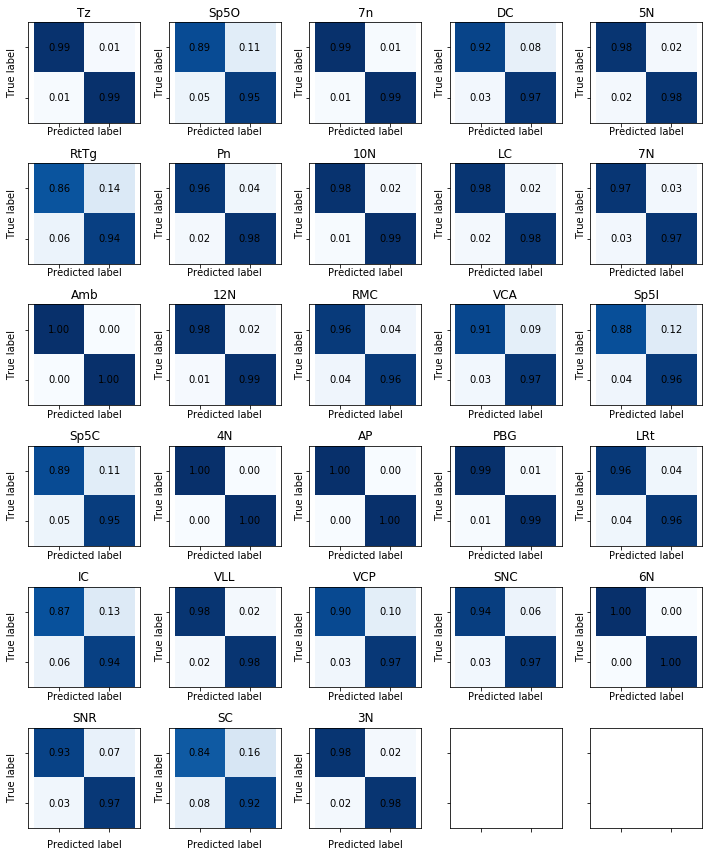

In [38]:
# Compute training accuracy

acc_all_structures = {}

ncols = 5
nrows = int(np.ceil(len(structures_found)/float(ncols)))

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*2, nrows*2), sharex=True, sharey=True)
axes = axes.flatten()

for i, structure in enumerate(structures_found):
        
    features_pos = training_features[structure]
    n_pos = len(features_pos)
    
#     if setting in [1, 3, 4, 5, 6, 7]:
#         neg_classes = [convert_to_surround_name(structure, margin=margin, suffix='noclass')]
#     elif setting in [2, 10, 23, 24, 25, 26]:
#         neg_classes = [convert_to_surround_name(structure, margin=margin, suffix='noclass')]            
#         for surr_l in structures_found:
#             c = convert_to_surround_name(structure, margin=margin, suffix=surr_l)
#             if c in labels_found:
#                 neg_classes.append(c)
#     elif setting in [8,9,11]:
#         neg_classes = [structure + '_negative']
#     else:
#         sys.stderr.write('Setting is not recognized.\n')
#         raise

#     if setting in [1, 3, 4, 5, 6, 7]:
    if neg_composition == 'neg_has_only_surround_noclass':
        neg_classes = [convert_to_surround_name(structure, margin=margin, suffix='noclass')]
#     elif setting in [2, 10, 23, 24, 25, 26]:
    elif neg_composition == 'neg_has_all_surround':
        neg_classes = [convert_to_surround_name(structure, margin=margin, suffix='noclass')]
        for surr_s in structures_found:
            c = convert_to_surround_name(structure, margin=margin, suffix=surr_s)
            if c in labels_found:
                neg_classes.append(c)
#     elif setting in [8,9,11]:
    elif neg_composition == 'neg_has_everything_else':
        neg_classes = [structure + '_negative']
    else:
        raise Exception('Setting is not recognized.')
        
        
    features_neg = np.concatenate([training_features[neg_class] for neg_class in neg_classes])
#     neg_distances = np.concatenate([distances_to_structures[neg_class][label] for neg_class in neg_classes])
        
    n_neg = len(features_neg)
    
    train_data = np.r_[features_pos, features_neg]
    train_labels = np.r_[np.ones((features_pos.shape[0], )), 
                         -np.ones((features_neg.shape[0], ))]
    
    clf = clf_allClasses[structure]
    
    probs = clf.predict_proba(train_data)[:, clf.classes_.tolist().index(1.)]
    cm = compute_confusion_matrix(np.c_[probs, 1-probs], [0 if l==1. else 1 for l in train_labels], soft=True)
    
    acc_all_structures[structure] = (n_pos*cm[0,0] + n_neg*cm[1,1])/(n_pos + n_neg)
    
    plot_confusion_matrix(cm, title='%(structure)s'% {'structure':structure},
                          labels=['',''],
#                           labels=[label, convert_to_surround_name(label)],
                         axis=axes[i])
#     plt.show();

plt.tight_layout()

In [39]:
print 'training accuracy:', np.mean(acc_all_structures.values())

training accuracy: 0.965931997682


In [ ]:
# Visualize training patches

patches = extract_patches_given_locations_multiple_sections(training_addresses['12N'][:10], 
                                                            location_or_grid_index='grid_index',
                                                            version='compressed')
display_images_in_grids(patches, nc=10)

# patches = extract_patches_given_locations_multiple_sections(training_addresses['12N_surround'][:10], 
#                                                             location_or_grid_index='grid_index',
#                                                             version='compressed')
# display_images_in_grids(patches, nc=10)

In [34]:
def patch_boxes_overlay_on(bg, downscale_factor, locs, patch_size, colors=None, stack=None, sec=None):
    """
    Assume bg has the specified downscale_factor.
    """

    if bg == 'original':
        bg = imread(DataManager.get_image_filepath(stack=stack, section=sec, version='compressed'))[::downscale_factor, ::downscale_factor]
       
    # viz = bg.copy()
    viz = gray2rgb(bg).copy()
    # need copy() because of this bug http://stackoverflow.com/a/31316516
    
    half_size = patch_size/2/downscale_factor
    if isinstance(locs[0], list):
        if colors is None:
            colors = random_colors(len(locs))
        for i, locs_oneColor in enumerate(locs):
            for x, y in locs_oneColor:
                x = x / downscale_factor
                y = y / downscale_factor
                cv2.rectangle(viz, (x-half_size, y-half_size), (x+half_size, y+half_size), colors[i], 2)
    else:
        if colors is None:
            colors = (255,0,0)
        for x, y in locs:
            x = x / downscale_factor
            y = y / downscale_factor
            cv2.rectangle(viz, (x-half_size, y-half_size), (x+half_size, y+half_size), colors, 2)
            
    return viz

In [35]:
# Visualize a patch in context

patch_size, stride, _, _ = get_default_gridspec('MD589')
grid_locations = grid_parameters_to_sample_locations(get_default_gridspec('MD589'))
viz = patch_boxes_overlay_on('original', 8, 
                       [grid_locations[44453]],
                      patch_size=patch_size,
                      stack='MD589',
                       sec=219)
display_image(viz)

/shared/MouseBrainAtlas/learning/tmp.jpg